In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians
from category_encoders import BinaryEncoder
from datetime import datetime
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
# load dataset
df = pd.read_csv('airbnb_dataset_clean.csv')
df.head()

,neighbourhood,host_since,host_listings_count,host_identity_verified,property_type,room_type,accommodates,beds,price,log_price,location_cluster
0,North Beach,2015-08-18,1,1,Entire condo,Entire home/apt,4,2,417.0,6.035481,0
1,South of Market,2021-07-29,32,1,Entire serviced apartment,Entire home/apt,2,1,280.0,5.638355,0
2,Noe Valley,2013-12-07,1,1,Entire condo,Entire home/apt,4,2,195.0,5.278115,3
3,South of Market,2014-06-02,1,1,Private room in home,Private room,2,1,60.0,4.110874,0
4,Castro/Upper Market,2012-03-02,1,0,Private room in condo,Private room,1,1,120.0,4.795791,1


In [3]:
# check missing values
df.isna().sum()

neighbourhood             0
host_since                0
host_listings_count       0
host_identity_verified    0
property_type             0
room_type                 0
accommodates              0
beds                      0
price                     0
log_price                 0
location_cluster          0
dtype: int64

## Feature Engineering

In [4]:
# change 'host_since' to show duration instead of dates
df['host_since'] = pd.to_datetime(df['host_since'])
df['host_duration_days'] = (datetime.now() - df['host_since']).dt.days

# drop the original 'host_since' column
df = df.drop(columns=['host_since'])

## Encoding

In [5]:
# binary encoding for 'property_type'
binary_encoder = BinaryEncoder(cols=['property_type'])
df = binary_encoder.fit_transform(df)

In [6]:
# one-hot encoding for 'room_type'
df = pd.get_dummies(df, columns=['room_type'])
df.head()

,neighbourhood,host_listings_count,host_identity_verified,property_type_0,property_type_1,property_type_2,property_type_3,property_type_4,property_type_5,accommodates,beds,price,log_price,location_cluster,host_duration_days,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,North Beach,1,1,0,0,0,0,0,1,4,2,417.0,6.035481,0,3039,1,0,0,0
1,South of Market,32,1,0,0,0,0,1,0,2,1,280.0,5.638355,0,867,1,0,0,0
2,Noe Valley,1,1,0,0,0,0,0,1,4,2,195.0,5.278115,3,3658,1,0,0,0
3,South of Market,1,1,0,0,0,0,1,1,2,1,60.0,4.110874,0,3481,0,0,1,0
4,Castro/Upper Market,1,0,0,0,0,1,0,0,1,1,120.0,4.795791,1,4303,0,0,1,0


## Splitting Dataset

In [7]:
# split the dataset
X = df.drop(['neighbourhood','price', 'log_price'], axis=1) # neighborhood is not relevant for predictions
y = df['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [8]:
# check shape of the train and test data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5406, 16)
(5406,)
(1802, 16)
(1802,)


## Model Selection

* Since the data has many outliers, **Mean Absolute Error (MAE)** seems to be the suitable metric to evaluate the models.
* MAE would avoid magnifying the impact of extreme errors on the metric, by not squaring them.

### Model 1: Linear Regression

In [9]:
# initiate model
linear_reg = LinearRegression()

# perform cross-validation on training set
cv_scores = cross_val_score(linear_reg, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
mae_scores = -cv_scores

print("Linear Regrression Cross-Validation Mean MAE:", round(np.mean(mae_scores), 4))

Linear Regrression Cross-Validation Mean MAE: 0.4275


### Model 2: Random Forest Regressor

In [10]:
# initiate model
random_forest_reg = RandomForestRegressor(random_state=123)

# perform cross-validation on training set
cv_scores = cross_val_score(random_forest_reg, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
mae_scores = -cv_scores

print("Random Forest Regression Cross-Validation Mean MAE:", round(np.mean(mae_scores), 4))

Random Forest Regression Cross-Validation Mean MAE: 0.3303


It is evident that **Random Forest Regressor** is the better performing model for our dataset.

### Hyperparameter Tuning

In [11]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}

# perform grid search with cross-validation
grid_search = GridSearchCV(estimator=random_forest_reg, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

# print the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 500}


## Final Modeling

In [12]:
best_rf_model = RandomForestRegressor(random_state=123, **best_params)
best_rf_model.fit(X_train, y_train)
preds = best_rf_model.predict(X_test)
mae = mean_absolute_error(y_test, preds)

print(f"Random Forest Mean Absolute Error: {mae:.4f}")

Random Forest Mean Absolute Error: 0.3261


### Model Performance Visualization

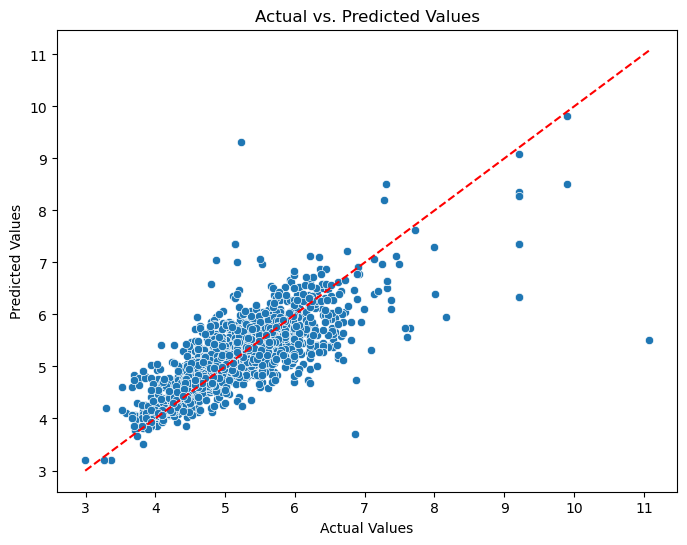

In [13]:
# plot actual values vs predicted valules
actual_values = y_test
predicted_values = best_rf_model.predict(X_test)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=actual_values, y=predicted_values)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], linestyle='--', color='red')
plt.show()

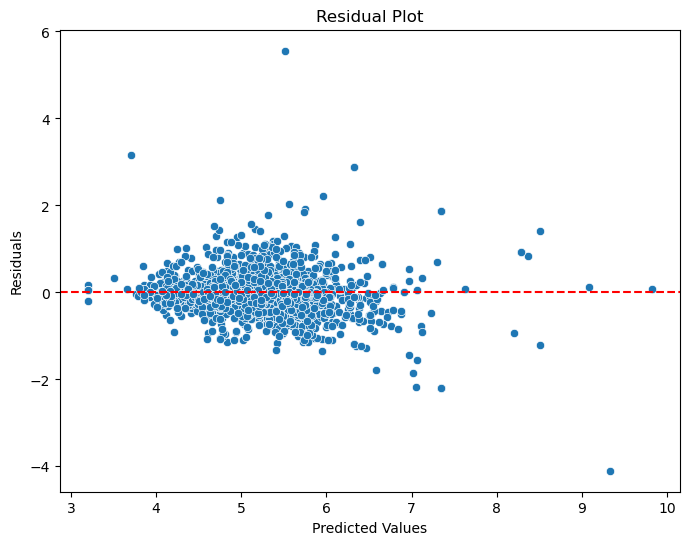

In [14]:
# residual plot
residuals = y_test - predicted_values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=predicted_values, y=residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

### Feature Importance

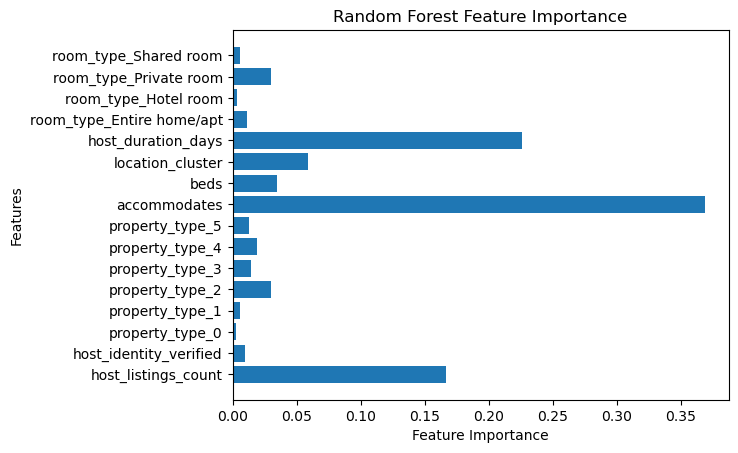

In [15]:
feature_importances = best_rf_model.feature_importances_

feature_names = X.columns.tolist()

# visualize feature importance
plt.barh(range(len(feature_importances)), feature_importances, align="center")
plt.yticks(range(len(feature_importances)), feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Features")  
plt.title("Random Forest Feature Importance")
plt.show()

* The most influential features include **'accommodates' (\~37%), 'host_duration_days' (\~23%),** and **'host_listings_count' (\~17%)**. These suggest that property capacity, host experience, and host activity significantly impact rental prices.
* **'location_cluster'** holds some importance as well **(~6%)**, indicating that specific neighborhood clusters do contribute to variations in Airbnb rental prices.
* Other features have significantly lesser impact on predicting rental prices.

## Conclusion

* The final Random Forest model achieved Mean Absolute Error (MAE) of approx. **0.33** on the test set, which makes it a reliable tool for estimating Airbnb rental prices, for the city of San Francisco. 
* **'Accommodates'** stands out as the most impactful feature, emphasizing that the property's capacity plays a pivotal role in determining Airbnb rental prices in San Francisco.
* Additionally, the duration a person has been an Airbnb host **('Host_duration_days')** and the number of properties they have listed **('host_listings_count')** are important factors in determining rental prices. 
* Future work could explore enhancements, such as incorporating temporal trends or experimenting with advanced modeling techniques, to further refine the predictive capabilities of the model.